In [1]:
import torch
from torch import nn
from torch.utils import data
import matplotlib.pyplot as plt
from IPython import display

## 高维线性回归

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw+b 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

In [4]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1))*0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size)

## 从零开始实现

In [5]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return w, b

In [6]:
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

In [7]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None, ylim=None,
                xscale='linear', yscale='linear', legend=None,
                fmts=('-', 'm--', 'g-.', 'r:')):
        ## 增量地绘制多条线
        legend = [] if legend is None else legend
        self.fig, self.axes = plt.gcf(), plt.gca()
        self.config_axes = lambda: self.set_axes(xlabel, ylabel, xlim, ylim, xscale, yscale, legend) ## 使用lambda表达式捕获变量
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        self.axes.set_xlabel(xlabel)
        self.axes.set_ylabel(ylabel)
        self.axes.set_xlim(xlim)
        self.axes.set_ylim(ylim)
        self.axes.set_xscale(xscale)
        self.axes.set_yscale(yscale)
        self.axes.legend(legend)
        self.axes.grid()

    def add(self, x, y):
        """向图表中添加多个数据点"""
        y = [y] if not hasattr(y, "__len__") else y
        x = [x] * len(y) if not hasattr(x, "__len__") else x
        self.X = [[] for _ in range(len(y))] if self.X is None else self.X
        self.Y = [[] for _ in range(len(y))] if self.Y is None else self.Y
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes.cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes.plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [8]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [9]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [10]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [11]:
class Accumulator:
    def __init__(self, n):
        self.data = [.0] * n
    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [.0] * len(self.data)
    def __getitem__(self, i):
        return self.data[i]

In [12]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)     ## 损失的总和、样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [13]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda x: linreg(x, w, b), squared_loss
    num_epochs, lr = 100, 0.003
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='linear', xlim=[5,num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), 
                                     evaluate_loss(net, test_iter, loss)))
    
    print('w的L2范数是: ', torch.norm(w).item())    

w的L2范数是:  13.734369277954102


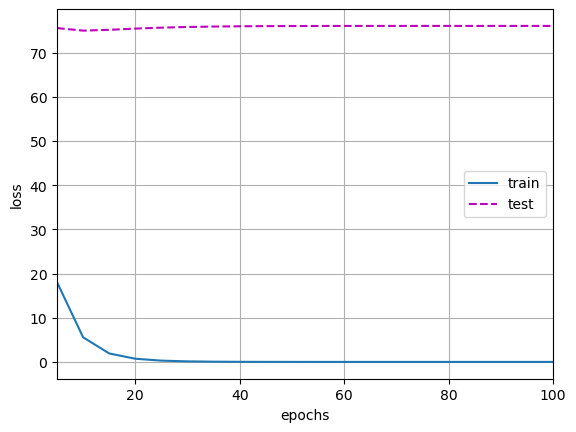

In [14]:
train(lambd=0)

w的L2范数是:  0.3399833142757416


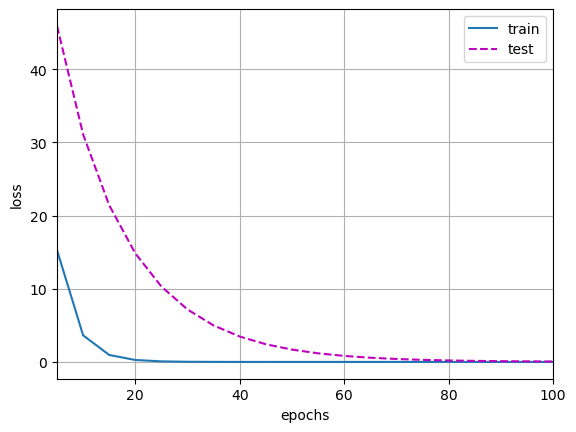

In [15]:
train(lambd=3)

## 简洁实现

In [28]:
def train_concise(wd):
    net = nn.Sequential(
        nn.Linear(num_inputs, 1)
    )
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([
        {"params": net[0].weight, "weight_decay": wd},
        {"params": net[0].bias,}
    ], lr = lr)
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='linear', xlim=[5,num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch+1) % 5  == 0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss),
                                   evaluate_loss(net, test_iter, loss)))
    print('w的L2范数: ', net[0].weight.norm().item())

w的L2范数:  14.02670669555664


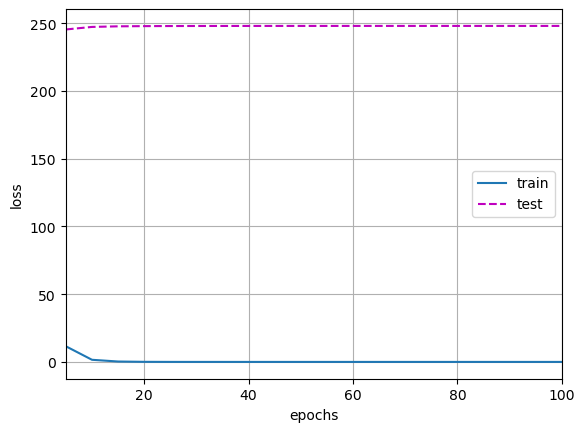

In [29]:
train_concise(0)

w的L2范数:  0.40264517068862915


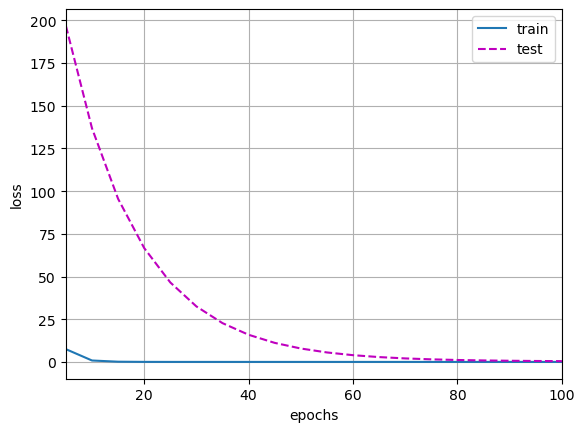

In [30]:
train_concise(3)

## Exercises

1. 在本节的估计问题中使用$\lambda$的值进行实验。绘制训练和测试精度关于$\lambda$的函数。观察到了什么？

2. 使用验证集来找到最佳值$\lambda$。它真的是最优值吗？这有关系吗？

3. 如果我们使用$\sum_i|w_i|$作为我们选择的惩罚（$L_1$正则化），那么更新方程会是什么样子？

4. 我们知道$||w||^2 = w^Tw$。能找到类似的矩阵方程吗?

5. 回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练数据、使用适当复杂度的模型之外，还能想出其他什么方法来处理过拟合？

6. 在贝叶斯统计中，我们使用先验和似然的乘积，通过公式$P(w|x) \propto P(x|w)P(w)$得到后验。如何得到带正则化的$P(w)$？